<a href="https://colab.research.google.com/github/satani99/practical_deep_learning_for_coders/blob/main/fast_ai_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [2]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [3]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [4]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [5]:
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [6]:
df1 = pd.DataFrame()
df1['a'] = [1, 2, 3, 4]
df1

,a
0,1
1,2
2,3
3,4


In [7]:
df1['b'] = [10, 20, 30, 40]
df1['c'] = df1['a'] + df1['b']
df1

,a,b,c
0,1,10,11
1,2,20,22
2,3,30,33
3,4,40,44


In [8]:
dblock = DataBlock()

In [9]:
dsets = dblock.datasets(df)

In [10]:
dsets.train[0]

(fname       007579.jpg
 labels          person
 is_valid          True
 Name: 3822, dtype: object, fname       007579.jpg
 labels          person
 is_valid          True
 Name: 3822, dtype: object)

In [11]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.valid[0]

('005336.jpg', 'sofa person')

In [12]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock), get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 1.]))

In [13]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['tvmonitor']

In [14]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid 

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter = splitter,
                   get_x = get_x,
                   get_y = get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

In [15]:
dls = dblock.dataloaders(df)

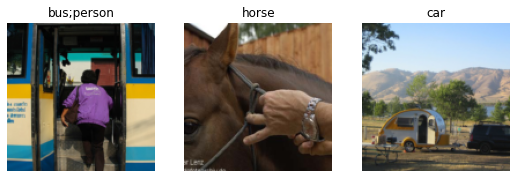

In [16]:
dls.show_batch(nrows=1, ncols=3)

In [17]:
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f370

  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [18]:
if torch.cuda.is_available():
    learn.model.cuda()

In [19]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [20]:
activs[0]

TensorBase([ 0.6479, -3.6220,  0.9967, -0.9248,  0.1225,  3.8561,  1.0114,
            -2.8824,  0.7642,  0.8462,  2.3400,  0.4472, -2.0620, -2.0652,
             1.3447,  1.8406, -0.2913,  0.2103, -1.8813, -0.6370],
           device='cuda:0', grad_fn=<AliasBackward0>)

In [21]:
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [22]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0679, device='cuda:0', grad_fn=<AliasBackward0>)

In [23]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  if sigmoid: inp = inp.sigmoid()
  return ((inp>thresh)==targ.bool()).float().mean()

In [24]:
def say_hello(name, say_what='Hello'): return f'{say_what} {name}.'
say_hello('Nikhil'), say_hello('Nikhil', 'Bonjour')

('Hello Nikhil.', 'Bonjour Nikhil.')

In [25]:
f = partial(say_hello, say_what='Ahoy!')
f('Nikhil')

'Ahoy! Nikhil.'

In [26]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.937759,0.696224,0.238825,00:30
1,0.821746,0.557080,0.289024,00:29
2,0.604017,0.203367,0.822052,00:30
3,0.360723,0.128490,0.936354,00:29


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.134967,0.116259,0.948327,00:30
1,0.115210,0.107783,0.951594,00:31
2,0.095938,0.101978,0.952928,00:30


In [27]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.10197833180427551,0.9316135048866272]

In [28]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.10197833180427551,0.9427289962768555]

In [29]:
preds, targs = learn.get_preds()

In [30]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)


TensorBase(0.9567)

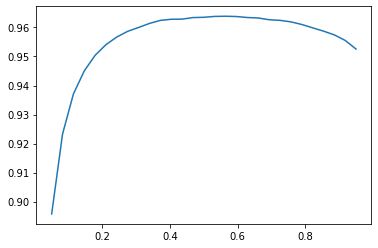

In [31]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

In [32]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [33]:
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/23'),Path('/root/.fastai/data/biwi_head_pose/03.obj'),Path('/root/.fastai/data/biwi_head_pose/23.obj'),Path('/root/.fastai/data/biwi_head_pose/13.obj'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/08'),Path('/root/.fastai/data/biwi_head_pose/09'),Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/21.obj'),Path('/root/.fastai/data/biwi_head_pose/18.obj')...]

In [34]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00185_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00448_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00276_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00381_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00157_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00241_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00281_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00478_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00476_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00151_pose.txt')...]

In [36]:
img_file = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_file[0])

Path('/root/.fastai/data/biwi_head_pose/23/frame_00448_pose.txt')

In [38]:
im = PILImage.create(img_file[0])
im.shape

(480, 640)

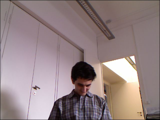

In [39]:
im.to_thumb(160)

In [40]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1, c2])

In [42]:
get_ctr(img_file[0])

tensor([350.9904, 331.5477])

In [43]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240, 320)),
                Normalize.from_stats(*imagenet_stats)]
)

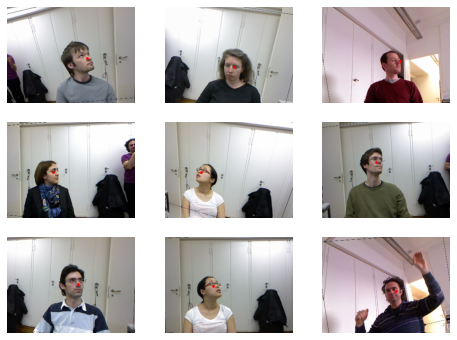

In [44]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8, 6))

In [45]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [46]:
yb[0]

TensorPoint([[0.0713, 0.2617]], device='cuda:0')

In [47]:
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [49]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0020892962347716093)

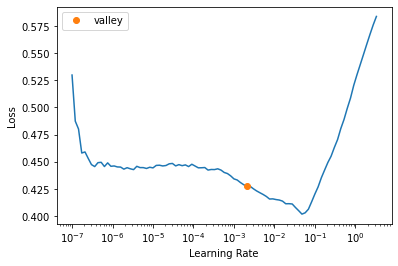

In [50]:
learn.lr_find()

In [57]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.012955,0.000629,02:03
1,0.003247,0.002261,02:00
2,0.002389,0.000253,02:00
3,0.001971,0.000696,01:58
4,0.001291,0.000122,02:00


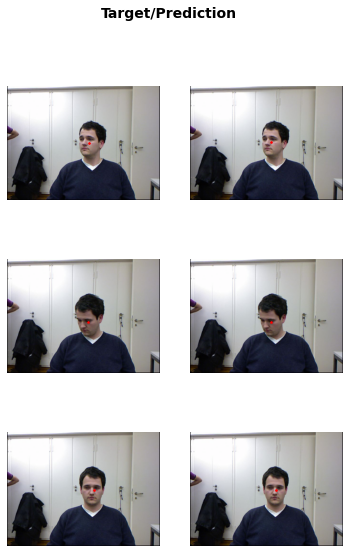

In [59]:
learn.show_results(ds_idx=1, max_n=3)